# Employee Turnover Prediction

## Context

Employee turnover is the rate at which employees leave a company or organisation. High employee turnover can be detrimental to a business, as it can lead to increased costs and reduced productivity.

The cost of replacing an employee is the total cost to hire and train a replacement employee, to the same level of productivity as the employee who left. The cost of recruiting, hiring and training can add up quickly, especially if the company has high turnover rate.

Recent report from [Work Institute’s 2017 Retention Report](https://www.benefitnews.com/news/avoidable-turnover-costing-employers-big?brief=00000152-14a7-d1cc-a5fa-7cffccf00000&utm_content=socialflow&utm_campaign=ebnmagazine&utm_source=twitter&utm_medium=social) estimates that it costs as much as 33% of a worker’s annual salary to replace. 

Therefore, in order to maintain productivity and save costs, businesses need to:
- Identify employees who is likely to leave
- Understand the biggest factors causing employee turnover
- Take steps to improve retention

From a machine learning perspective, this is **binary classification problem** since we are trying to predict either an employee left or not.

## Data

Employee turnover data sourced from [Kaggle](https://www.kaggle.com/datasets/marikastewart/employee-turnover).

**department** - the department the employee belongs to.   
**promoted** - 1 if the employee was promoted in the previous 24 months, 0 otherwise.   
**review** - the composite score the employee received in their last evaluation.  
**projects** - how many projects the employee is involved in.  
**salary** - for confidentiality reasons, salary comes in three tiers: low, medium, high.  
**tenure** - how many years the employee has been at the company.  
**satisfaction** - a measure of employee satisfaction from surveys.  
**bonus** - 1 if the employee received a bonus in the previous 24 months, 0 otherwise.  
**avghrsmonth** - the average hours the employee worked in a month.  
**left** - "yes" if the employee ended up leaving, "no" otherwise.  

## Assumptions

Because dataset has given no information about how the records were collected, I am making an assumption the records were collected in regular intervals (e.g. monthly or annually).

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# knn keeps generating warnings
import warnings
warnings.filterwarnings('ignore')

## Import Data 

In [2]:
df = pd.read_csv('employee_churn_data.csv')

In [3]:
# check the first few rows
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [4]:
# rename 'left' to 'turnover'
df.rename(columns={'left': 'turnover'}, inplace=True)

# convert 'tenure' to whole number for better display in plots
df['tenure'] = df['tenure'].apply(round)

In [5]:
# check number of rows and columns
df.shape

(9540, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   int64  
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   turnover       9540 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 745.4+ KB


There are no nulls, this is a complete dataset.  
7 numerical columns and 3 categorical (object) columns.  
Object columns will need to be encoded or converted to dummy variables during pre-processing.  

In [7]:
# double check
df.isnull().sum()

department       0
promoted         0
review           0
projects         0
salary           0
tenure           0
satisfaction     0
bonus            0
avg_hrs_month    0
turnover         0
dtype: int64

In [8]:
# check for any duplicates
df.duplicated().any()

False

There are no duplicate observations. Note that there are no unique employee identifiers in this dataset.

In [9]:
# check summary statistics for numeric columns
df.describe()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571
std,0.171403,0.085307,0.579136,1.415432,0.158555,0.408785,4.144831
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
25%,0.000000,0.592884,3.000000,5.000000,0.386801,0.000000,181.472085
50%,0.000000,0.647456,3.000000,7.000000,0.500786,0.000000,184.628796
75%,0.000000,0.708379,4.000000,8.000000,0.622607,0.000000,187.728708
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656


Observations:
- **Promoted** and **bonus** appear discrete. Mostly 0, meaning majority of employees have not been promoted or had bonus in last 24 months
- Average **review** score is 0.65. Small std indicates low spread.
- Median number of **projects** employee is involved in is 3. Range from 2 - 5 projects.
- Median **tenure** is 7 years. Range from 2 - 12 years.
- On average, employees spend 185 hours per month at work (9.2 hours per day).
- Minimum hours spent was 171 hours per month (8.5 hours per day). All employees worked longer than standard 8 hour days.

In [10]:
df.describe(include=object)

,department,salary,turnover
count,9540,9540,9540
unique,10,3,2
top,sales,medium,no
freq,1883,6611,6756


Observations:
- There are 10 **departments**. Sales department has the most number of employees.
- There are 3 **salary** bands. Majority in medium band.
- Majority of employees recorded during the intervals had not left.

We will visualise these observations during Exploratory Data Analysis (EDA).

## Exploratory Data Analysis

In [11]:
# percentage of employees that left
df['turnover'].value_counts(normalize=True, sort=False)*100

no     70.81761
yes    29.18239
Name: turnover, dtype: float64

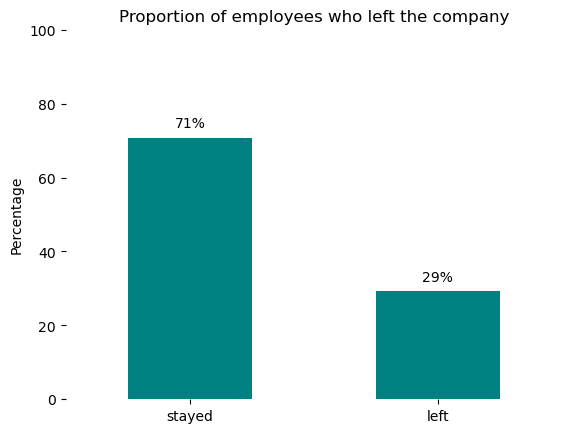

In [12]:
# visualise the percentage

count_turn = df['turnover'].value_counts(normalize=True, sort=False)*100

ax = count_turn.plot.bar(color='teal')
ax.set(ylabel="Percentage")
ax.set_ylim([0, 100])
ax.set_frame_on(False)
plt.xticks([0,1],['stayed', 'left'], rotation=0)
plt.title('Proportion of employees who left the company')

# place labels on bars
for p in ax.patches:
    ax.annotate(f'{round(p.get_height())}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

70% of employees recorded at the time have stayed with the company. 30% had left the company.

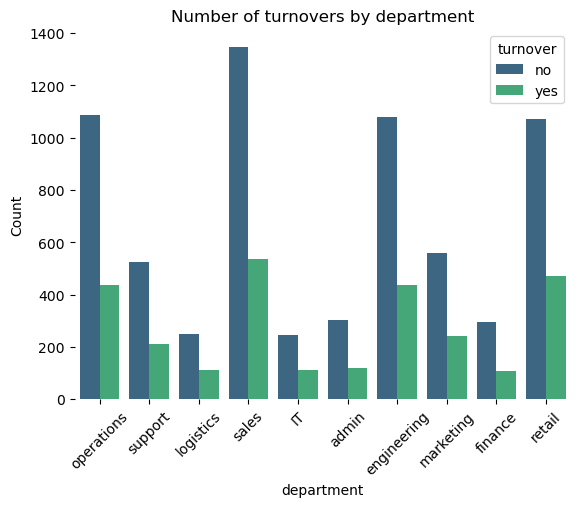

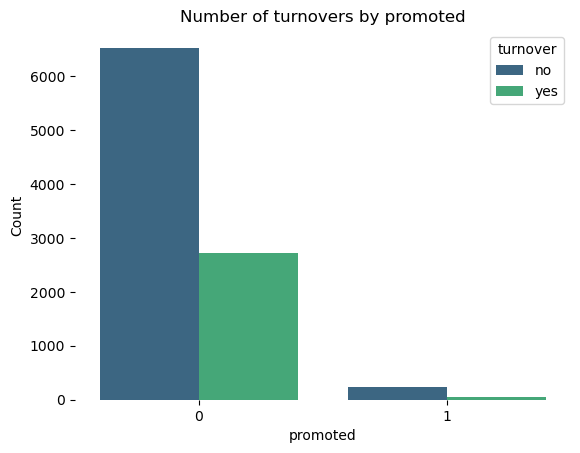

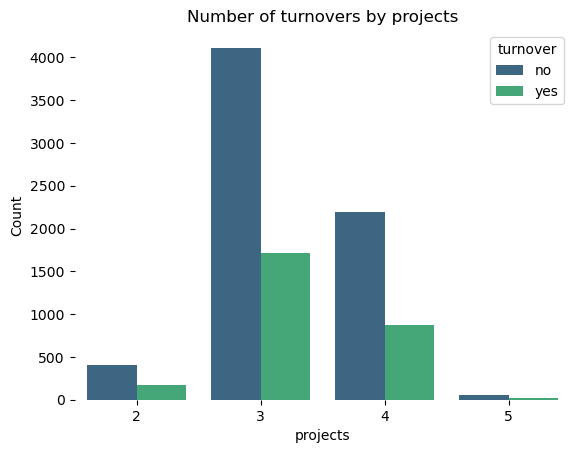

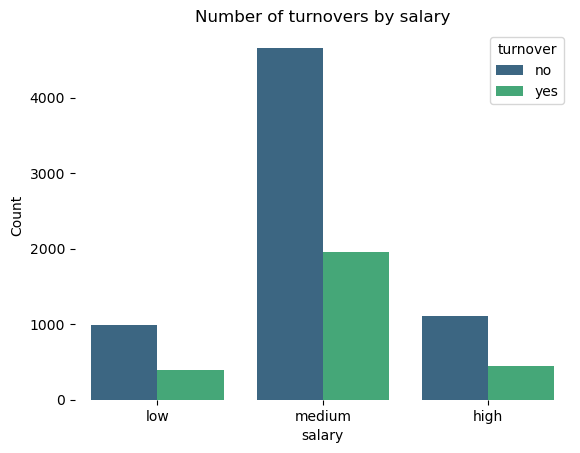

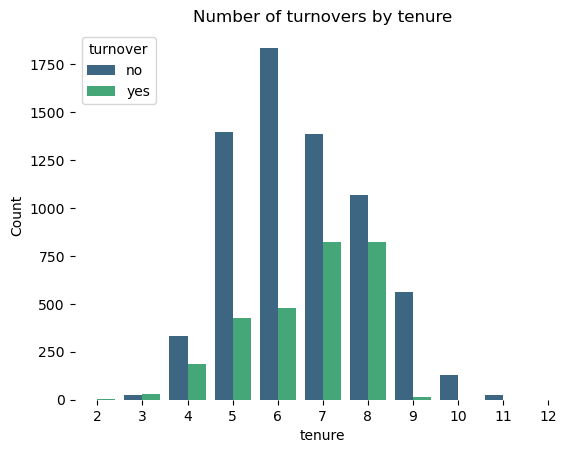

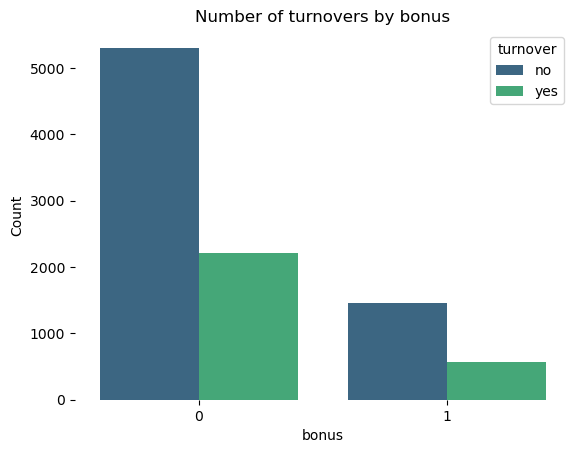

In [13]:
# for categorical or discrete columns, generate barplots

cat_features = ['department', 'promoted', 'projects', 'salary', 'tenure', 'bonus']

for feature in cat_features:
    ax = sns.countplot(data=df, x=feature, hue='turnover', palette='viridis')
    ax.set( ylabel='Count', title= f'Number of turnovers by {feature}')
    ax.set_frame_on(False)
    
    if feature == 'department':
        plt.xticks(rotation=45)
        
    plt.show()

Observations:
- Similar proportions of employee turnover was observed by **department** and **number of projects** involved.   
- **Salary** band did not appear to affect the turnover, which was different to my assumption that lower salary would lead to increased turnover. 
- Similar observation to salary was seen with **bonus**.  
- In **tenure**, proportion of turnover was highest in employees with <3 years tenure. Proportion gradually increased after 4 years, with a sharp drop past 8 years.
- There were no employees that left with tenure 10+ years.

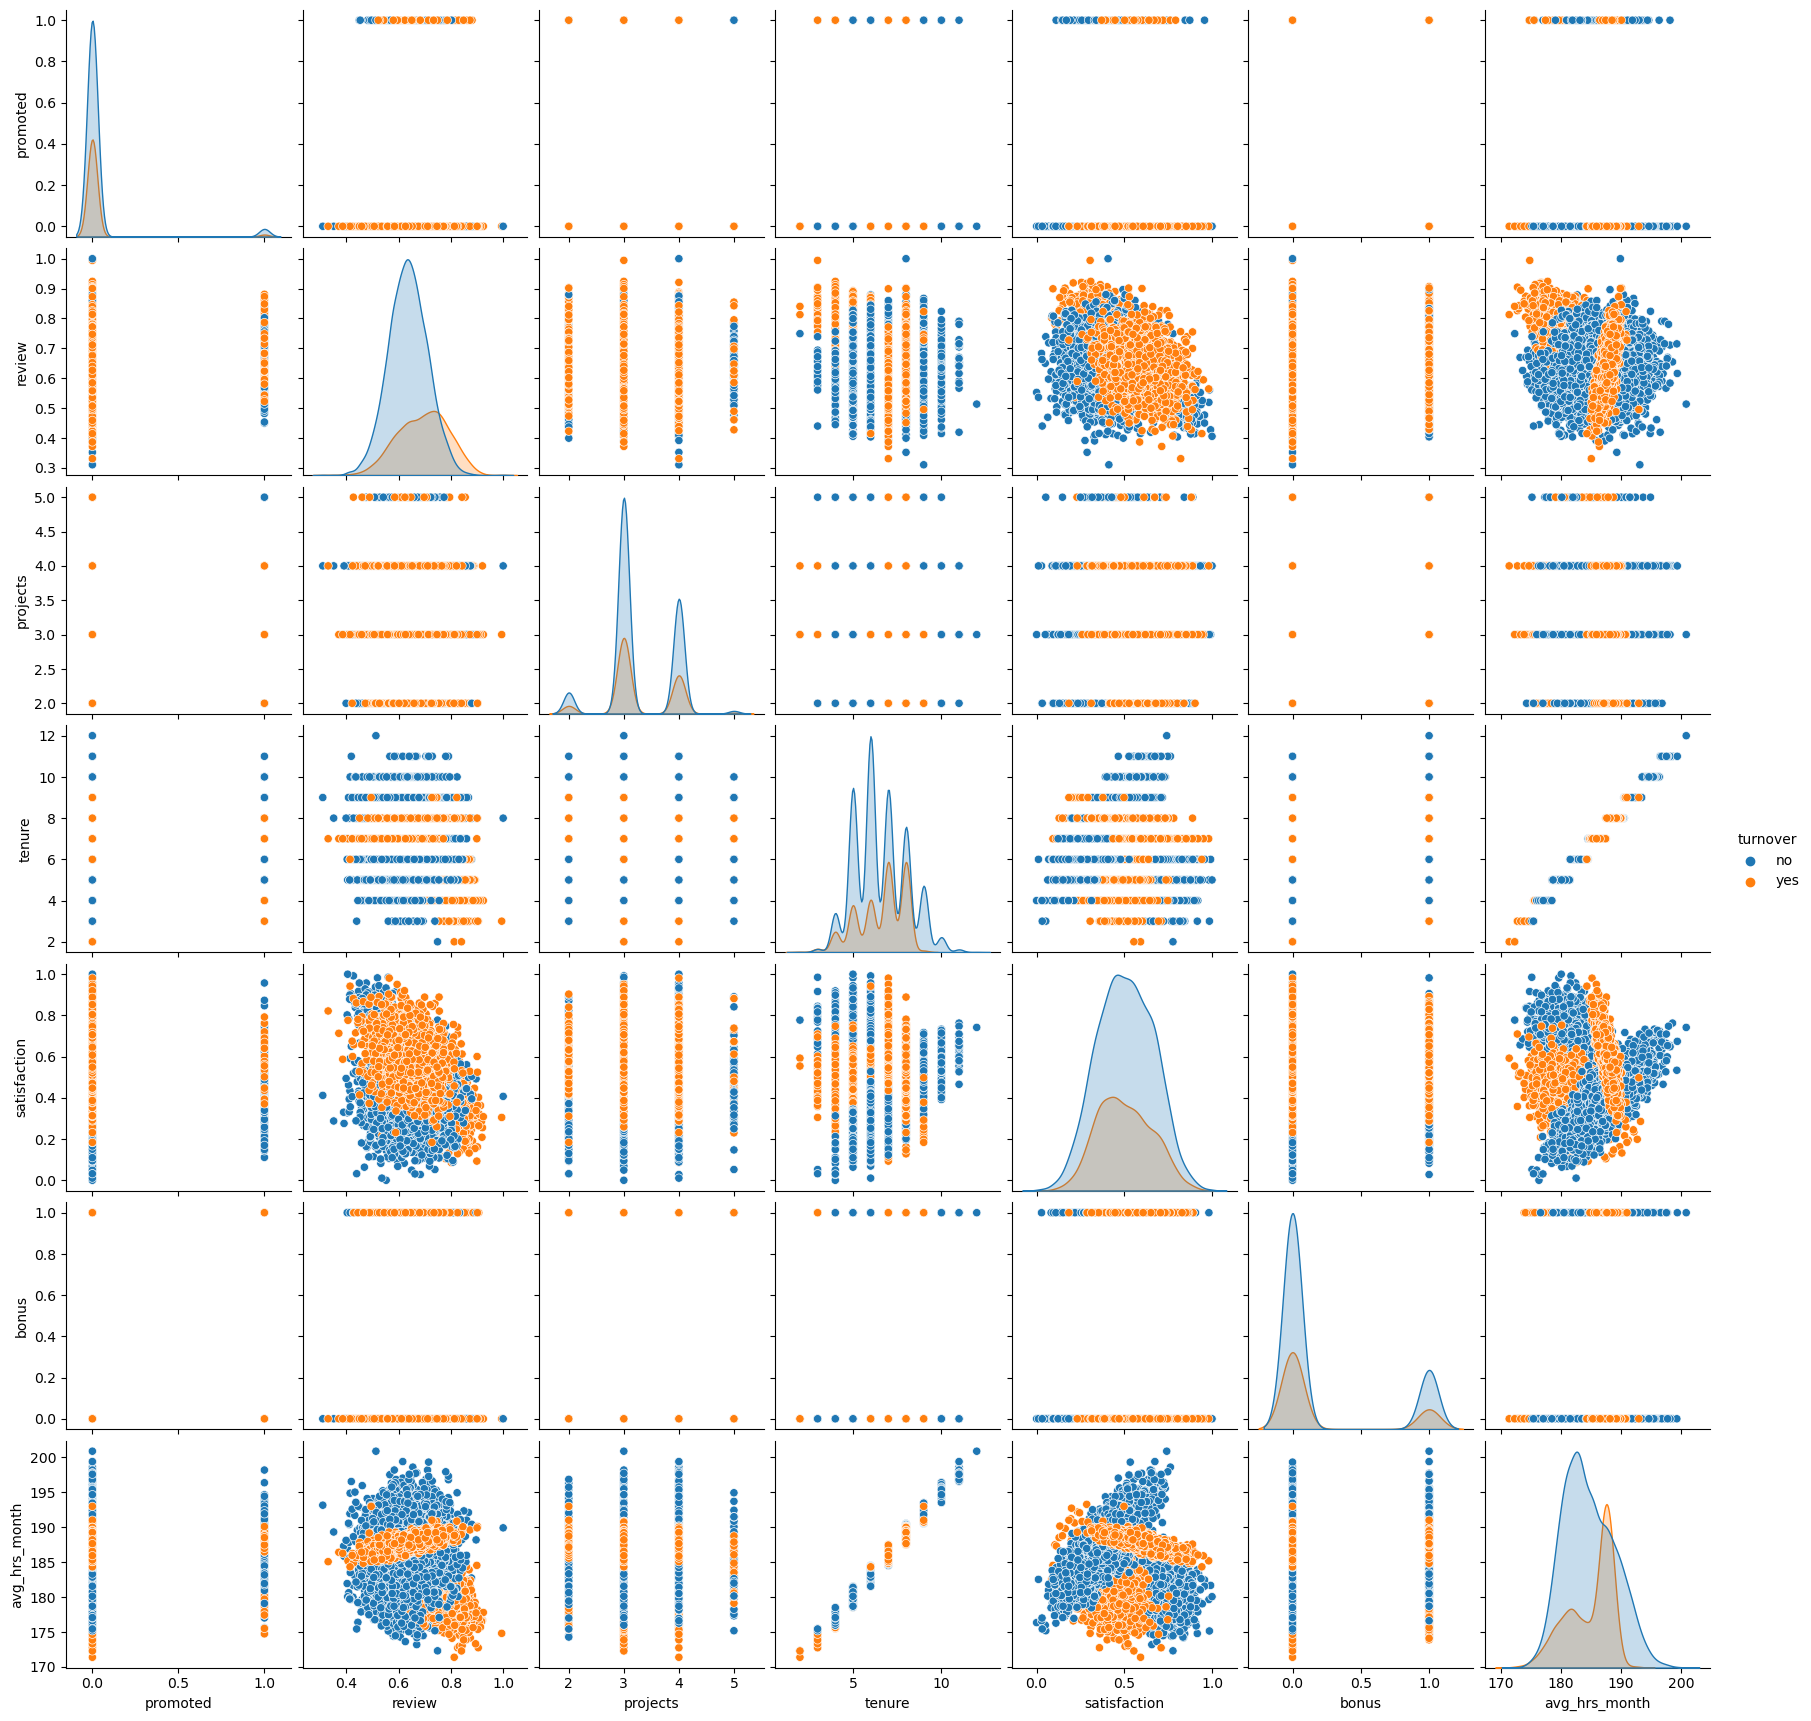

In [14]:
# try pairplot on the dataframe to check overall relationship and separability

_= sns.pairplot(df, hue='turnover')

- No variable combinations gives strong indication of linear separability.   
- Scatterplots of continuous variables (review, satisfaction, avg_hrs_month) show clustering.   
- Strong positive relationship between tenure and avg_hrs_month.

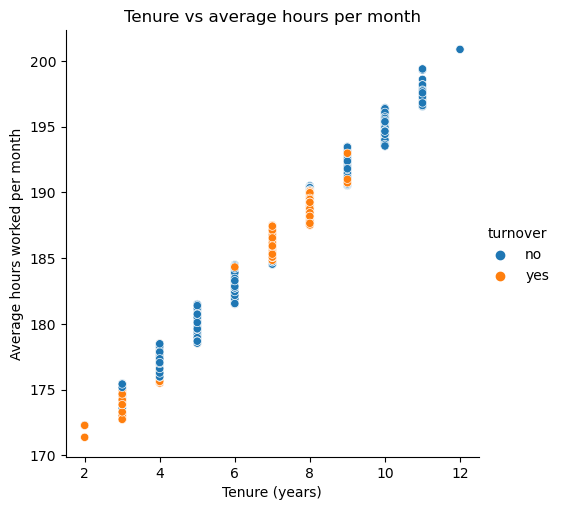

In [15]:
# look at tenure vs avg_hrs_month
sns.relplot(data=df, x='tenure', y='avg_hrs_month', hue='turnover')
plt.xlabel('Tenure (years)')
plt.ylabel('Average hours worked per month')
plt.title('Tenure vs average hours per month')
plt.show()

Indeed a very strong positive linear relationship. It's questionable how strongly correlated it is?   

Could consider removing one of the two features for modelling, since collinearity may affect performance.

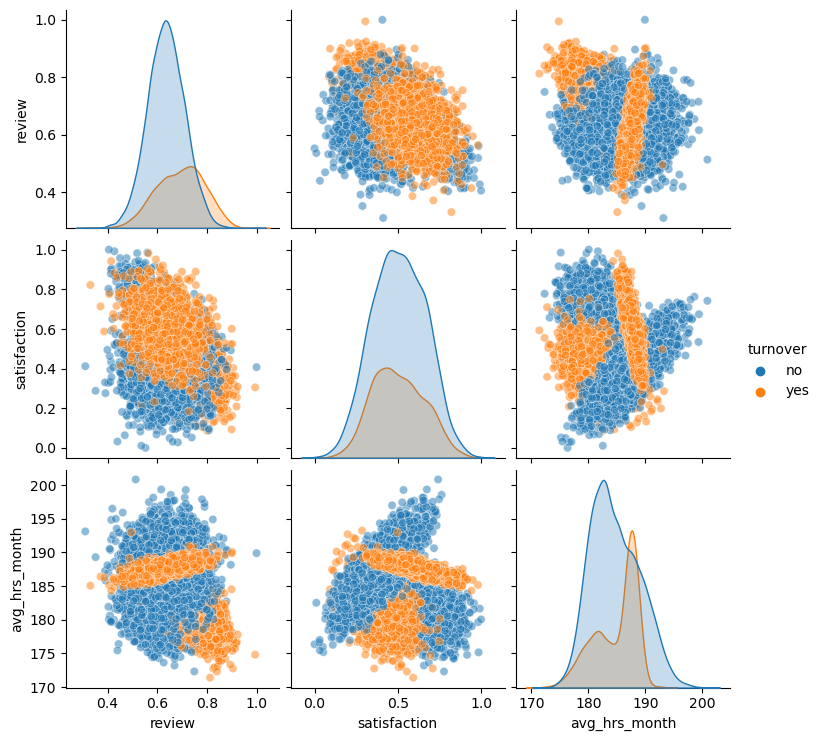

In [16]:
# separate pairplot of the continuous variables

sns.pairplot(df[['review', 'satisfaction', 'avg_hrs_month', 'turnover']], 
             kind='scatter', hue='turnover', plot_kws={'alpha': 0.5})


There are distinct clusters amongst these continuous variables.   

avg_hrs_month shows interesting distributions
- **Distribution** for employees that stayed at the company peaked around 180 hours. 
- For employees that left the company, there is a shallow peak around 180 hours followed by a sharp peak just below 190 hours.


It is difficult to know whether data is linearly separable from this, because the data is high dimensional and we are only looking at two variables at a time.   

Should still be taken into account when evaluating models that require linearly separable data (e.g. logistic regression). 

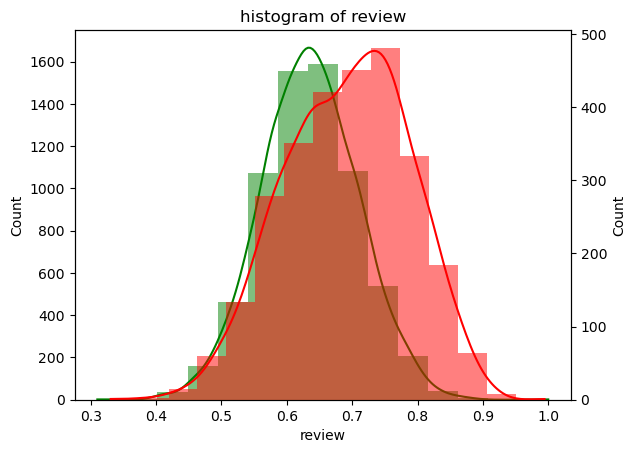

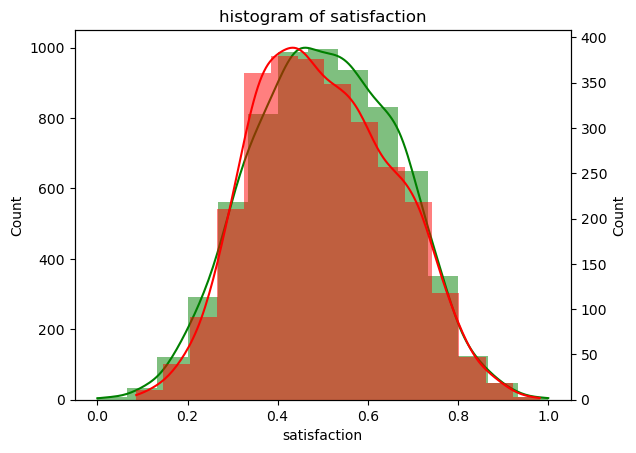

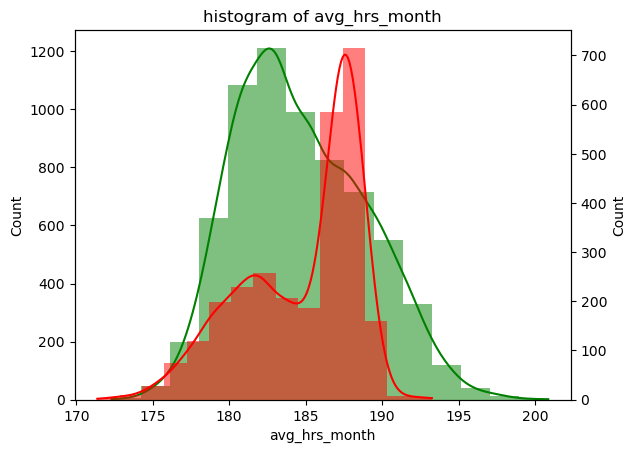

In [17]:
continuous_col = ['review', 'satisfaction', 'avg_hrs_month']

for feature in continuous_col:
    sns.histplot(df[df['turnover'] == 'no'][feature], bins=15, linewidth=0, kde=True, color='green')
    ax2 = plt.twinx()
    sns.histplot(df[df['turnover'] == 'yes'][feature], bins=15, linewidth=0, kde=True, color='red')
    
    plt.title(f'histogram of {feature}')
    plt.show()

Red = employee left, green = employee stayed

- **Avg_hrs_month** again shows interesting distribution for turnover=yes
- **Review** has similar distributions. Mean review appears higher for employees that left, suggest that higher performing employees tend to leave more
- **satisfaction** appears normally distributed for both turnover=yes and turnover=no

## Data Manipulation & Preprocessing

In [18]:
# turnover is the target column. Map to integers.

df['turnover'] = df['turnover'].map({"no": 0, "yes": 1})

In [19]:
# label encoding for salary as there is hierarchy

df['salary'] = df['salary'].map({'low': 1, "medium": 2, "high": 3})

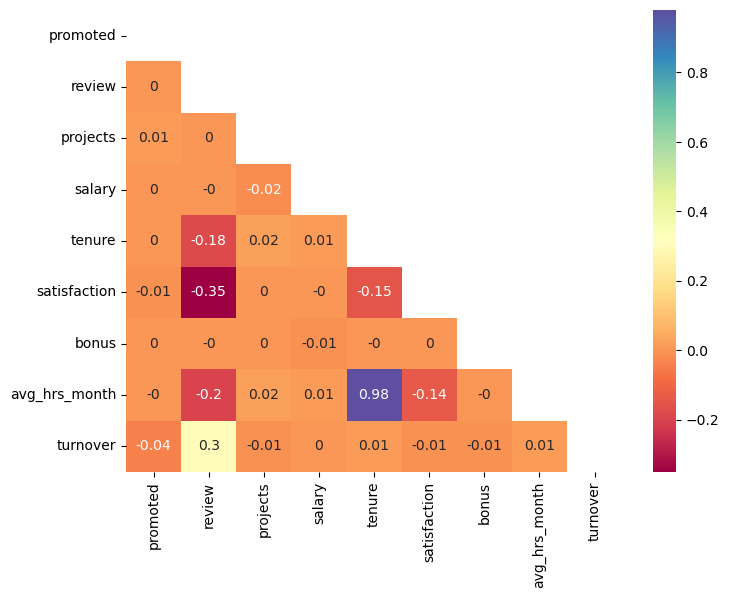

In [20]:
corr = df.corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8,6)) 
ax = sns.heatmap(corr, mask=mask, cmap='Spectral', annot=True)

Avg_hrs_month and tenure again shows very strong correlation, almost perfect (1). Strong doubt that this is legitimate.

In [21]:
# create dummy variables for remaining categorical feature - department
df = pd.get_dummies(df)

In [22]:
df.head()

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,turnover,department_IT,department_admin,department_engineering,department_finance,department_logistics,department_marketing,department_operations,department_retail,department_sales,department_support
0,0,0.577569,3,1,5,0.626759,0,180.866070,0,0,0,0,0,0,0,1,0,0,0
1,0,0.751900,3,2,6,0.443679,0,182.708149,0,0,0,0,0,0,0,1,0,0,0
2,0,0.722548,3,2,6,0.446823,0,184.416084,0,0,0,0,0,0,0,0,0,0,1
3,0,0.675158,4,3,8,0.440139,0,188.707545,0,0,0,0,0,1,0,0,0,0,0
4,0,0.676203,3,3,5,0.577607,1,179.821083,0,0,0,0,0,0,0,0,0,1,0


In [23]:
df.shape

(9540, 19)

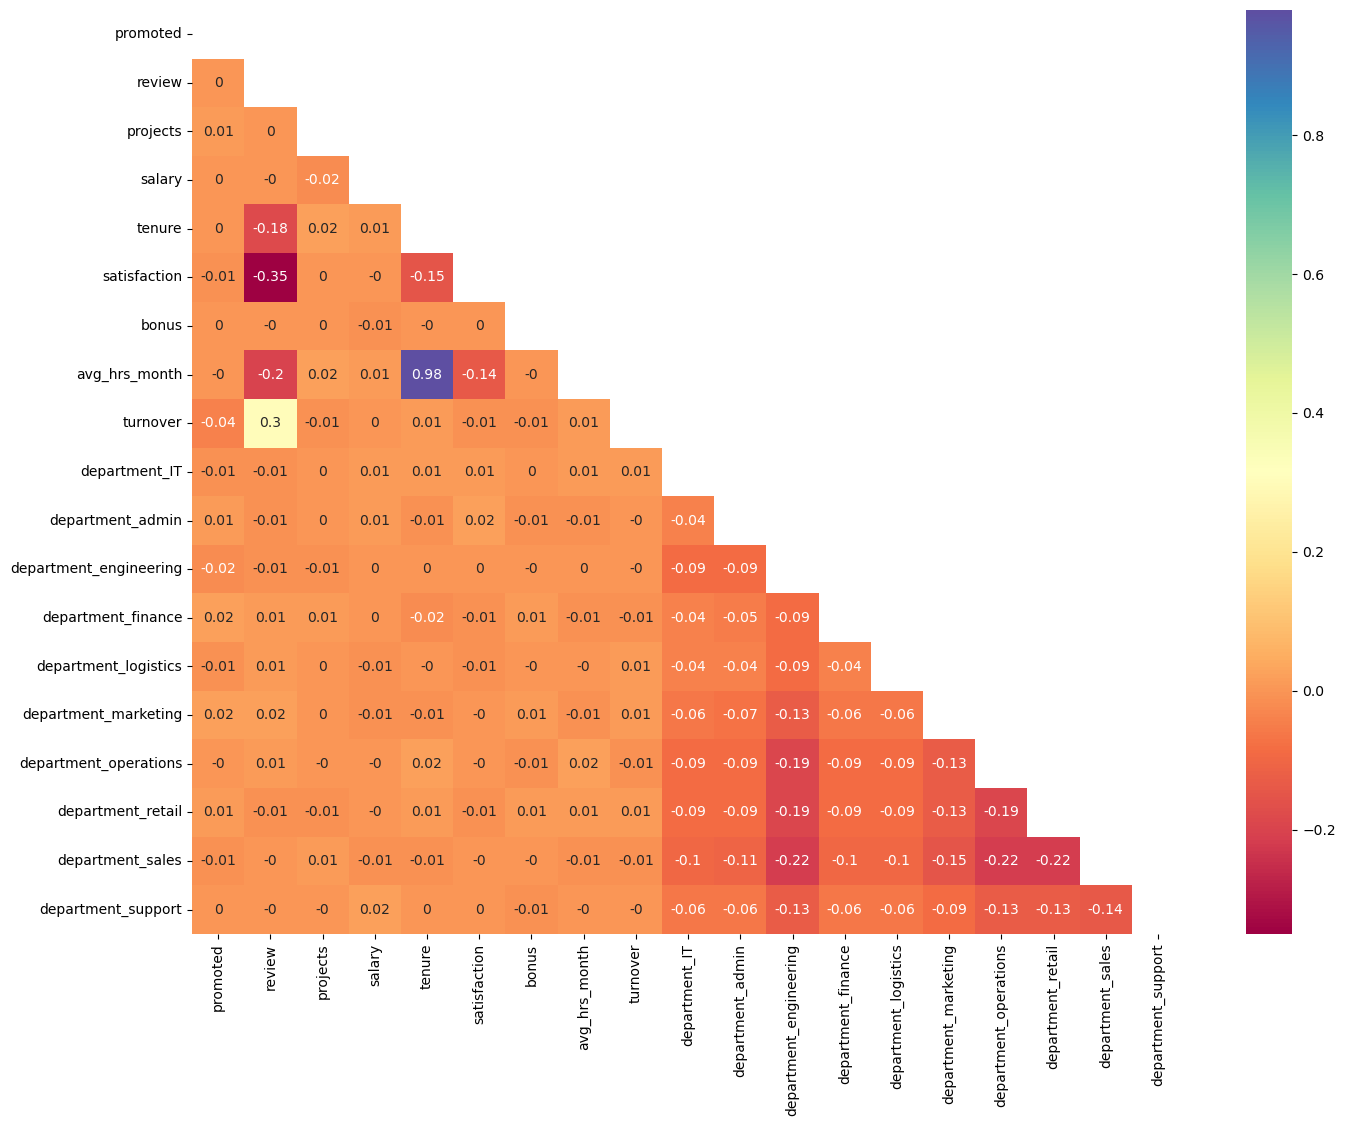

In [24]:
# check correlation matrix

corr = df.corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,12)) 
ax = sns.heatmap(corr, mask=mask, cmap='Spectral', annot=True)

From the matrix
- There is no strong correlation between target (turnover) and features. 
- Interestingly, there is a weak positive correlation between turnover and review score from employees.
- There is a very strong positive correlation between avg_hours_month and tenure. Employees work more hours on average as their tenure at the company increases.

Set the target and predictors. 
- Target column is 'turnover' 
- Drop 'tenure' as predictor due to collinearity
- Remaining 17 features are predictors.

In [25]:
# predictors
X = df.drop(['turnover', 'tenure'], axis=1)

# target
y = df['turnover']

In [26]:
X.shape, y.shape

((9540, 17), (9540,))

Split into train test subsets (4:1 ratio). These will be used to train and evaluate the models.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Modelling

Since this is a classification problem, following supervised algorithms will be used.

1. Logistic regression
2. SVM
3. Naive bayes
4. KNN


For each algorithm, below steps are performed.
- Instantiate chosen model
- Define range of hyperparameters
- Create pipeline with standard scaler and model instance
- GridSearchCV find best hyperparameters
- Fit train data on the optimal grid
- Evaluate model 

### Functions

First, some functions have been created to reduce code repetition.

In [28]:
# Purpose of this function is to simplify and streamline the model finding process for each algorithm.

# input - X_train, y_train, name of algorithm (str)
# output - model fit with the best hyperparameters 

def find_best_model(X_train, y_train, model_name):
    
    # initialise model classifier and parameters from input model name
    if model_name == 'log':
        clf = LogisticRegression(max_iter=5000, solver='liblinear')
        
        # regularisation
        params = {'log__C': np.logspace(-4, 4, 50),
                  'log__penalty': ['l1','l2']}

    elif model_name == 'svm':
        clf = svm.SVC(probability=True)
        
        # 'linear' kernal excluded to improve performance
        params = {'svm__C': [0.1, 1, 10, 100, 1000], 
                  'svm__gamma': [1, 0.1, 0.01, 0.001],
                  'svm__kernel': ['rbf']} 
        
    elif model_name == 'nb':
        clf = naive_bayes.GaussianNB()
        
        # only one parameter to tune
        params = {'nb__var_smoothing': np.logspace(0,-9, num=10)}
        
    elif model_name == 'knn':
        clf = KNeighborsClassifier()
        
        # try range of number of neighbours
        params = {'knn__n_neighbors': list(range(1, 30))}
        
    else:
        print('Invalid model given as input. Try using one of the following [log, svm, nb, knn]')
        return

    # Pipeline of chosen model with standard scaler
    pipe = Pipeline(steps=[('scaler', StandardScaler()), (model_name, clf)])
    
    # gridsearch to find the best parameters
    grid = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
    
    # fit train data on best grid
    grid.fit(X_train, y_train)
    
    print(f'Best parameters chosen for {model_name} model: {grid.best_params_}')
    
    # return best grid to evaluate test data
    return grid

In [29]:
# This function takes the best grid and test data as input
# outputs confusion matrix, fpr/tpr/auc

def evaluate_model(grid, X_test, y_test):
    
    # predictions
    y_pred = grid.predict(X_test)
    
    # display confusion matrix as plot
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stayed', 'Left']).plot()
              
    # predicted probabilities
    y_ppr = grid.predict_proba(X_test)

    # find FPR TPR
    fpr, tpr , _ = roc_curve(y_test, y_ppr[:, 1])

    # area under ROC curve
    roc_auc = auc(fpr, tpr)
    
    # display classification report
    print(classification_report(y_test, y_pred))
    
    # to be used later to compare each model in roc curve plot
    return fpr, tpr, roc_auc

## 1. Logistic Regression Model

First we will try logistic regression, with hyperparameter tuning for regularisation.

In [30]:
%%time 

grid_log = find_best_model(X_train, y_train, 'log')

Best parameters chosen for log model: {'log__C': 0.004291934260128779, 'log__penalty': 'l1'}
CPU times: user 793 ms, sys: 276 ms, total: 1.07 s
Wall time: 3.65 s


Gridsearch has found the best hyperparameters are L1 lasso regularisation with C=0.00429.   

In [31]:
cross_val_score(grid_log, X_train, y_train).mean()

0.7406976734205876

Mean cross validated accuracy score is 0.74

              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1337
           1       0.79      0.18      0.30       571

    accuracy                           0.74      1908
   macro avg       0.76      0.58      0.57      1908
weighted avg       0.75      0.74      0.68      1908



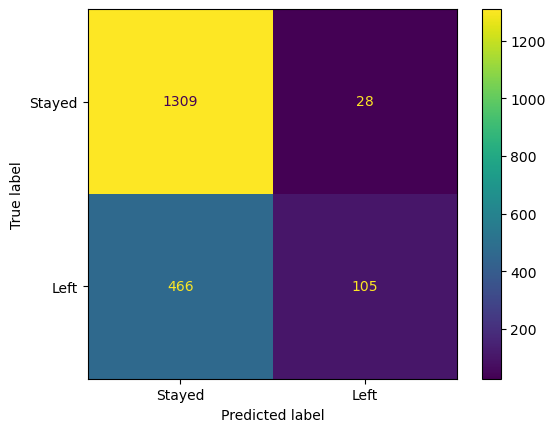

In [32]:
fpr_log, tpr_log, auc_log = evaluate_model(grid_log, X_test, y_test)

- Test accuracy score of 0.74
- Recall for turnover is low, only 18% of turnover was correctly predicted.
- There are 466 employees that actually left, but the model classified as stayed.

Large number of employees that actually end up leaving may not be well detected under this model.

## 2. SVM Model

Now try SVM, with hyperparameter tuning for C (regularisation) and gamma (kernal coefficient). 

In [33]:
%%time 

grid_svm = find_best_model(X_train, y_train, 'svm')

Best parameters chosen for svm model: {'svm__C': 1000, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
CPU times: user 21.5 s, sys: 326 ms, total: 21.8 s
Wall time: 4min 58s


Gridsearch has found the best hyperparameters are C=1000, gamma=0.01

In [42]:
%%time 

cross_val_score(grid_svm, X_train, y_train).mean()

CPU times: user 32.3 s, sys: 328 ms, total: 32.6 s
Wall time: 5min 44s


0.8223270440251572

Mean cross validated accuracy is 0.82

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1337
           1       0.77      0.55      0.64       571

    accuracy                           0.81      1908
   macro avg       0.80      0.74      0.76      1908
weighted avg       0.81      0.81      0.80      1908



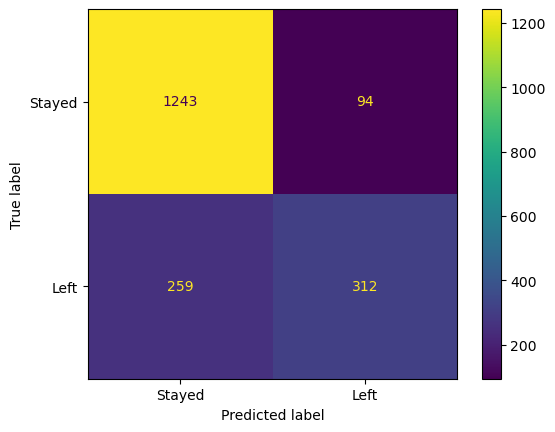

In [34]:
fpr_svm, tpr_svm, auc_svm = evaluate_model(grid_svm, X_test, y_test)

- Test accuracy of 0.81
- Precision of 0.77 for turnover, similar to logistic regression (0.79)
- Recall for turnover is 0.55, much higher than logistic regression (0.18)

Overall, SVM has performed a lot better than logistic regression.

## 3. Naive Bayes Model

Last model to fit is the naive bayes model, with just one hyperparameter tuned (var_smoothing).

Interstingly, it seems GridSearch isn't frequently used for naive bayes since there is just one parameter to optimise.

In [35]:
%%time 

grid_nb = find_best_model(X_train, y_train, 'nb')

Best parameters chosen for nb model: {'nb__var_smoothing': 0.1}
CPU times: user 125 ms, sys: 134 ms, total: 259 ms
Wall time: 2.27 s


Gridsearch has found the best hyperparameter is var_smoothing = 0.1

In [36]:
cross_val_score(grid_nb, X_train, y_train).mean()

0.7345406964718081

Mean cross validated accuracy is 0.73

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1337
           1       0.64      0.31      0.42       571

    accuracy                           0.74      1908
   macro avg       0.70      0.62      0.63      1908
weighted avg       0.72      0.74      0.71      1908



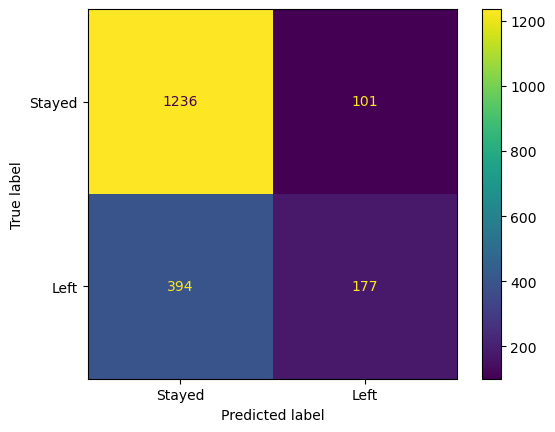

In [37]:
fpr_nb, tpr_nb, auc_nb = evaluate_model(grid_nb, X_test, y_test)

Findings for Naive Bayes
- Test accuracy is 0.74, equal to logistic regression
- Precision for turnover is 0.64, lower than both other models.
- Recall for turnover is 0.31, lower than SVM but higher than logistic regression.

Overall SVM appears to be the best model, especially with a significantly higher recall score than logistic regression and naive bayes models.

Similar cross validation score and test scores indicate we are not overfitting.

## 4. KNN Model

KNN is something I tried as extra, since it's still a supervised classification model.

Not included in presentation.

In [38]:
%%time 

grid_knn = find_best_model(X_train, y_train, 'knn')

/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

Best parameters chosen for knn model: {'knn__n_neighbors': 4}
CPU times: user 571 ms, sys: 190 ms, total: 761 ms
Wall time: 6.13 s


/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/rubyj/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer b

In [39]:
grid_knn.best_params_

{'knn__n_neighbors': 4}

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1337
           1       0.74      0.46      0.57       571

    accuracy                           0.79      1908
   macro avg       0.77      0.69      0.71      1908
weighted avg       0.78      0.79      0.77      1908



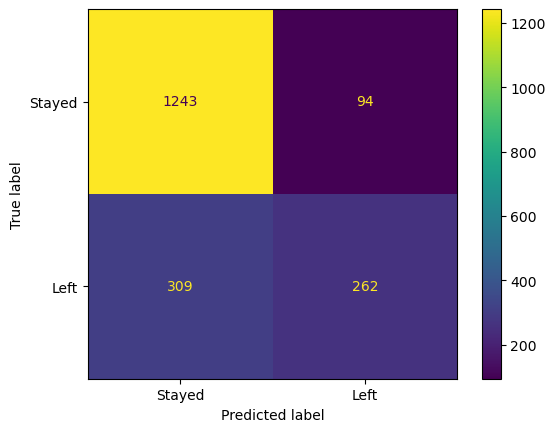

In [40]:
fpr_knn, tpr_knn, auc_knn = evaluate_model(grid_knn, X_test, y_test)

- Test accuracy of 0.79
- It did better in recall than logistic regression and naive bayes.

Still SVM seems to be better.

## ROC Curve Analysis

In a ROC curve, the metric of interest is the area under curve (AUC). This is a measure of how well the model can distinguish between two classes (employee left vs stayed). 

High auc indicates a good classification performance by the model.

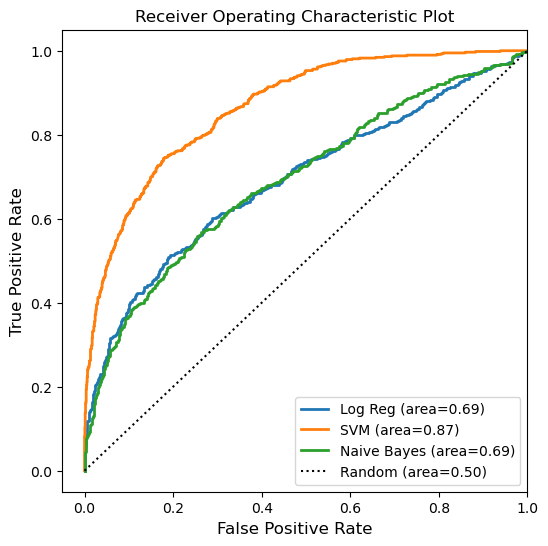

In [41]:
plt.figure(figsize=[6,6])
plt.plot(fpr_log, tpr_log, lw=2, label='Log Reg (area=%0.2f)' % auc_log)
plt.plot(fpr_svm, tpr_svm, lw=2, label='SVM (area=%0.2f)' % auc_svm)
plt.plot(fpr_nb, tpr_nb, lw=2, label='Naive Bayes (area=%0.2f)' % auc_nb)
plt.plot([0, 1], [0, 1], linestyle='dotted', label='Random (area=0.50)', color='black')
# plt.plot(fpr_knn, tpr_knn, lw=2, label='KNN (area=%0.2f)' % auc_knn)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic Plot', fontsize=12)
plt.legend(loc="lower right")
plt.show()

- SVM has the highest area of 0.87
- Same performance for logistic regression and naive bayes

# Conclusion

SVM model was found to be the most effective for predicting employee turnover.
- Achieved 81% accuracy on the test dataset
- Best classification ability (auc = 0.87)
- Can be used as a preliminary tool for targeted employee retention

## Next Steps

- Explore ways to gather more information about employees
- Improve recall score
- Explore feature selection techniques to identify key factors behind turnover 